In [121]:
import numpy as np
import nibabel as nib
import glob
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from tifffile import imsave
from sklearn.preprocessing import MinMaxScaler
import os

This part of the code to get an initial understanding of the dataset.

1 Load sample images and visualize

2 Includes, dividing each image by its max to scale them to [0,1]

3 Converting mask from float to uint8

4 Changing mask pixel values (labels) from 4 to 3 (as the original labels are 0, 1, 2, 4)

5 Visualize

View a few images

In [250]:
scaler = MinMaxScaler()

TRAIN_DATASET_PATH = 'd:\BraTS2020\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData'
#VALIDATION_DATASET_PATH = 'BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'

test_image_flair=nib.load(TRAIN_DATASET_PATH + '\BraTS20_Training_355/BraTS20_Training_355_flair.nii').get_fdata()
print("Max:",test_image_flair.max())
print("Shape:",test_image_flair.shape)
#Scalers are applied to 1D so let us reshape and then reshape back to original shape. 
test_image_flair=scaler.fit_transform(test_image_flair.reshape(-1, test_image_flair.shape[-1])).reshape(test_image_flair.shape)


test_image_t1=nib.load(TRAIN_DATASET_PATH + '\BraTS20_Training_355/BraTS20_Training_355_t1.nii').get_fdata()
test_image_t1=scaler.fit_transform(test_image_t1.reshape(-1, test_image_t1.shape[-1])).reshape(test_image_t1.shape)

test_image_t1ce=nib.load(TRAIN_DATASET_PATH + '\BraTS20_Training_355/BraTS20_Training_355_t1ce.nii').get_fdata()
test_image_t1ce=scaler.fit_transform(test_image_t1ce.reshape(-1, test_image_t1ce.shape[-1])).reshape(test_image_t1ce.shape)

test_image_t2=nib.load(TRAIN_DATASET_PATH + '\BraTS20_Training_355/BraTS20_Training_355_t2.nii').get_fdata()
test_image_t2=scaler.fit_transform(test_image_t2.reshape(-1, test_image_t2.shape[-1])).reshape(test_image_t2.shape)


Max: 1854.603271484375
Shape: (240, 240, 155)


Now, we take the mask's values and we reencode them to the specifications that we need for the labels.

In [251]:
test_mask=nib.load(TRAIN_DATASET_PATH + '\BraTS20_Training_355/BraTS20_Training_355_seg.nii').get_fdata()
test_mask=test_mask.astype(np.uint8)

print("Original mask's values:", np.unique(test_mask))  #0, 1, 2, 4 (Need to reencode to 0, 1, 2, 3)
test_mask[test_mask==4] = 3  #Reassign mask values 4 to 3
print("Updated values:",np.unique(test_mask)) 
print("Max:",test_mask.max())
print("Shape:",test_mask.shape)

Original mask's values: [0 1 2 4]
Updated values: [0 1 2 3]
Max: 3
Shape: (240, 240, 155)


Once we have reshaped and reencoded the data, we select a random subset of the data to visualize the images.

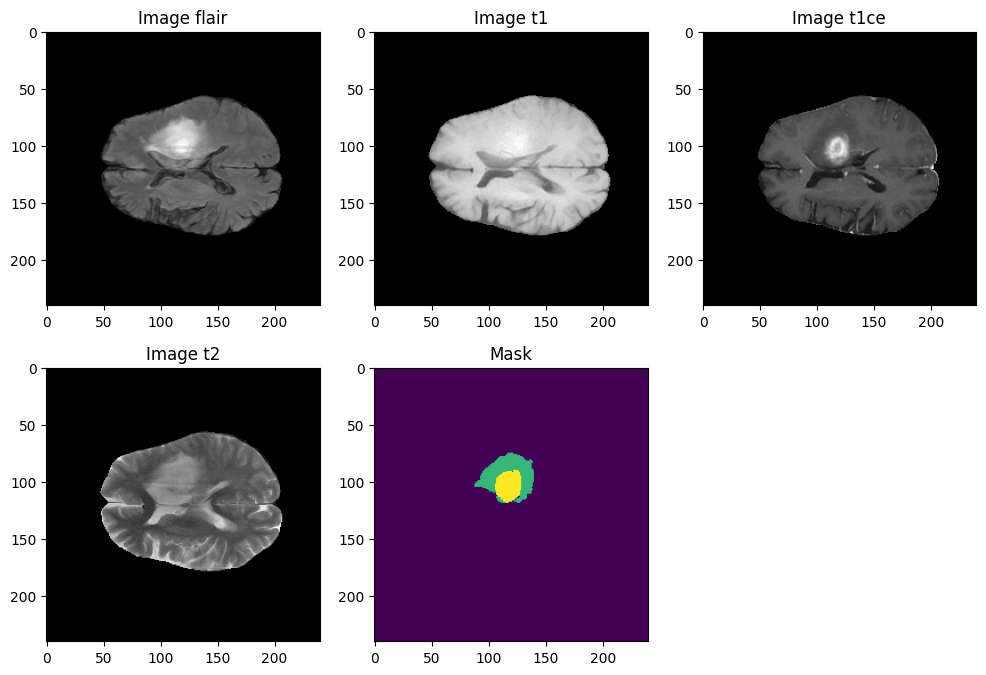

In [238]:
import random
n_slice=random.randint(0, test_mask.shape[2])

plt.figure(figsize=(12, 8))

plt.subplot(231)
plt.imshow(test_image_flair[:,:,n_slice], cmap='gray')
plt.title('Image flair')
plt.subplot(232)
plt.imshow(test_image_t1[:,:,n_slice], cmap='gray')
plt.title('Image t1')
plt.subplot(233)
plt.imshow(test_image_t1ce[:,:,n_slice], cmap='gray')
plt.title('Image t1ce')
plt.subplot(234)
plt.imshow(test_image_t2[:,:,n_slice], cmap='gray')
plt.title('Image t2')
plt.subplot(235)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

Now that we have our test images loaded (channels), let's combine them into a single volume array for the training process. Note that T1 couldn't provide significant information for the training set, so we decide to exclude T1 from the volume array."

Includes:
Combining 3 images to 3 channels of a numpy array (Flair, T1CE, annd T2 have the most information).
Combine t1ce, t2, and flair into single multichannel image

In [252]:
combined_x = np.stack([test_image_flair, test_image_t1ce, test_image_t2], axis=3)
#Crop to a size to be divisible by 64 so we can later extract 64x64x64 patches. 
#cropping x, y, and z
#combined_x=combined_x[24:216, 24:216, 13:141]
#combined_x=combined_x[50:190, 50:190, 13:141]
combined_x=combined_x[56:184, 56:184, 13:141] #Crop to 128x128x128x4 beause we have dark sides  (there's no information) of the 3d volume.

#Do the same for mask
test_mask = test_mask[56:184, 56:184, 13:141]
#test_mask = test_mask[50:190, 50:190, 13:141]


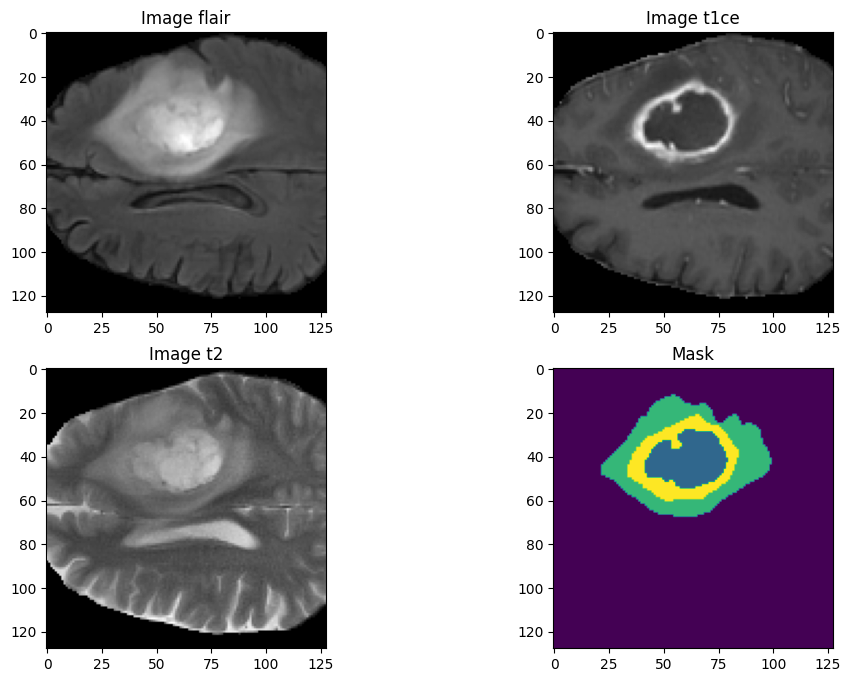

Image's shape: (128, 128, 128, 3)
Mask's shape: (128, 128, 128)


In [258]:
n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))
plt.subplot(221)
plt.imshow(combined_x[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(combined_x[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(combined_x[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()


print("Image's shape:",combined_x.shape)

print("Mask's shape:",test_mask.shape)


At this juncture, we have the option to save the data in various formats. Firstly, there's the tifffile option, which allows us to save multichannel files. However, attempting to open these files using tifffile might seem perplexing unless Python is utilized. On the other hand, if the data is saved as a numpy array, it can be easily opened, facilitating the handling of multiple channels.

In [261]:
imsave('combined255.tif', combined_x)
np.save('combined255.npy', combined_x)
#Verify image is being read properly
#my_img=imread('BraTS2020_TrainingData/combined255.tif')


C:\Users\Windows\AppData\Local\Temp\ipykernel_12760\2514809132.py:1: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  imsave('combined255.tif', combined_x)


Now that we saved it , let's go ahead and load the same to check the process

In [263]:
my_img=np.load('combined255.npy')
print("Loaded image's shape:",my_img.shape)
test_mask = to_categorical(test_mask, num_classes=4)

Loaded image's shape: (128, 128, 128, 3)


End of undestanding the dataset, now lets get started applying the same as above al the images

In [267]:
#Keras datagenerator does ntot support 3d

# # # images lists harley
# We are going to combine t2_list, t1ce_list, flair_list into a single volume and we're going to convert the mask into categorical

#t1_list = sorted(glob.glob('BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t1.nii'))

t2_list = sorted(glob.glob(TRAIN_DATASET_PATH + '\*\*t2.nii'))
t1ce_list = sorted(glob.glob(TRAIN_DATASET_PATH + '\*\*t1ce.nii'))
flair_list = sorted(glob.glob(TRAIN_DATASET_PATH + '\*\*flair.nii'))
mask_list = sorted(glob.glob(TRAIN_DATASET_PATH + '\*\*seg.nii'))


In [270]:
print(len(t2_list))
print(len(t1ce_list))
print(len(flair_list))

369
369
369


In [ ]:
#Each volume generates 18 64x64x64x4 sub-volumes. 
#Total 369 volumes = 6642 sub volumes
PATH_SAVE = 'd:\BraTS2020'
for img in range(len(t2_list)):   #Using t1_list as all lists are of same size
    print("Now preparing image and masks number: ", img)
      
    temp_image_t2=nib.load(t2_list[img]).get_fdata()
    temp_image_t2=scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)
   
    temp_image_t1ce=nib.load(t1ce_list[img]).get_fdata()
    temp_image_t1ce=scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)
   
    temp_image_flair=nib.load(flair_list[img]).get_fdata()
    temp_image_flair=scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)
        
    temp_mask=nib.load(mask_list[img]).get_fdata()
    temp_mask=temp_mask.astype(np.uint8)
    temp_mask[temp_mask==4] = 3  #Reassign mask values 4 to 3
    #print(np.unique(temp_mask))
    
    #once we obtained the images, we're goint to stack the flair, t1ce and t2 together along the axis 3
    temp_combined_images = np.stack([temp_image_flair, temp_image_t1ce, temp_image_t2], axis=3)
    
    #Crop to a size to be divisible by 64 so we can later extract 64x64x64 patches. 
    #cropping x, y, and z
    temp_combined_images=temp_combined_images[56:184, 56:184, 13:141]
    temp_mask = temp_mask[56:184, 56:184, 13:141]

    '''these gives us the number of zero's, one's, two's and three's in the mask, we do this because if i look at a volume, if that volume
    has less than one percent of my mask im not going to use it
    '''
    val, counts = np.unique(temp_mask, return_counts=True) 
    

    if (1 - (counts[0]/counts.sum())) > 0.01:  
        print("Save Me")

        # Verifica si el archivo ya existe
        img_filename = PATH_SAVE + '\input_data_3channels/images/image_' + str(img) + '.npy'
        mask_filename = PATH_SAVE + '\input_data_3channels/masks/mask_' + str(img) + '.npy'

        if not os.path.exists(img_filename) and not os.path.exists(mask_filename):
            temp_mask = to_categorical(temp_mask, num_classes=4)
            np.save(img_filename, temp_combined_images)
            np.save(mask_filename, temp_mask)
            print("Files saved successfully.")
        else:
            print(f"Files with index {img} already exist. Skipping.")

    else:
        print("I am useless")

   

Now that the volumes have been saved, the next step involves their segmentation into training and testing sets. Once the new folders are created rename them and arrange in the format below to be used for semantic segmentation using data generators. 

In [1]:
import splitfolders  # or import split_folders

input_folder = 'd:/BraTS2020/input_data_3channels/'
output_folder = 'd:/BraTS2020/train_dataset/'
# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.75, .25), group_prefix=None) # default values

Copying files: 688 files [18:14,  1.59s/ files]
